# Imports

In [19]:
import copy
from multiprocessing import Pool, cpu_count
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from qutip import *
from scipy.integrate import quad
from tqdm.auto import tqdm

from Twoqubit_functions import *

# Parameters

In [5]:
# Two qubit parameters
ϵ1 = 1  # energy of the 1st qubit
ϵ2 = 1  # energy of the 2nd qubit
g = 0.5 * ϵ1  # coupling strength
a=(2*np.sqrt(g**2+2*ϵ1*(np.sqrt(g**2+4*ϵ1**2)+2*ϵ1)))/(g-2*ϵ1-np.sqrt(g**2+4*ϵ1))
b=(2*np.sqrt(g**2-2*ϵ1*(np.sqrt(g**2+4*ϵ1**2)-2*ϵ1)))/(g-2*ϵ1+np.sqrt(g**2+4*ϵ1))


ωs = 1/2*np.sqrt(g**2+4*ϵ1**2) - g/2  # driving frequencies
ωp = 1/2*np.sqrt(g**2+4*ϵ1**2) + g/2  # driving frequencies
γ = 0.00 * ϵ1  # arbitray value of decay rate

# Drives
Ωs = 0.05 * ϵ1  # pulse amplitude
Ωp = 0.05 * ϵ1
T = 2000 / ϵ1  # the width of the pulses
τ = 0.7 * T  # overlap time
t = np.linspace(-5 * T, 5 * T, 300)


def pulse_ab(t, args):
    g = args["g"]
    ωs = args["ωs"]  
    ωp = args["ωp"] 
    term1 = (
        b*args["Ωs"] * np.cos(ωs * t) * (np.exp(-(((t + args["τ"]) / args["T"]) ** 2)))
    )
    term2 = (
        a*args["Ωp"] * np.cos(ωp * t) * (np.exp(-(((t - args["τ"]) / args["T"]) ** 2)))
    )
    return term1 + term2



# Noise parameters
N = 1101
t_noise = np.linspace(-5 * T, 5 * T, N)
σ = 0.01 * ϵ1  # width of the Gaussian distribution of noise
δ_lower, δ_higher = -5 * σ, 5 * σ
δrange = np.linspace(δ_lower, δ_higher, 311)


## Hamiltonian in qubit basis

In [6]:
# Definition of states and operators

sz1 = tensor(sigmaz(), identity(2))
sx1 = tensor(sigmax(), identity(2))
sp1 = tensor(sigmap(), identity(2))
sm1 = tensor(sigmam(), identity(2))
sz2 = tensor(identity(2), sigmaz())
sx2 = tensor(identity(2), sigmax())
sp2 = tensor(identity(2), sigmap())
sm2 = tensor(identity(2), sigmam())

zero = basis(2, 0)
one = basis(2, 1)

states = [
    (-((np.sqrt(g**2+4*ϵ1**2)+2*ϵ1)/g)*tensor(zero, zero)+tensor(one,one)).unit(),  # state 0 
    (+((np.sqrt(g**2+4*ϵ1**2)-2*ϵ1)/g)*tensor(zero, zero)+tensor(one,one)).unit(),  # state 1 
    (tensor(one, zero) + tensor(zero, one)).unit(),  # state 2 
    (tensor(zero, one) - tensor(one, zero)).unit(),  # state 3 
]


O = [[states[i] * states[j].dag() for j in range(4)] for i in range(4)]


ψ0 = states[0]  # initial state of the system
H0 = 0.5 * (-ϵ1 * sz1 - ϵ1 * sz2 + g * (tensor(sigmax(),sigmax())))  # Time independent Hamiltonian
Hc = (sx1 + sx2) / np.sqrt(2)  # control Hamiltonian

pars = {
    "ϵ1": ϵ1,
    "ϵ2": ϵ2,
    "Ωs": Ωs,
    "Ωp": Ωp,
    "g": g,
    "ωs": ωs,
    "ωp": ωp,
    "τ": τ,
    "T": T,
    "γ": γ,
    "Hc": Hc,
    "H0": H0,
    "ψ0": ψ0,
    "N": N,
    "δrange": δrange
}

## Plotting of populations for fixed parameters

In [45]:
δ1 = 0.002 * ϵ1  # local noise on the first qubit
δ2 = -0.002* ϵ1  # local noise on the second
H_ = get_H(δ1, δ2, pulse_ab, pars)

In [46]:
opts = Options(normalize_output=False, atol=1e-11, rtol=1e-9, nsteps=100000)
result = mesolve(H_, ψ0, t, args=pars, options=opts, progress_bar=False)

populations = [expect(O, result.states) for O in [O[0][0], O[1][1], O[2][2], O[3][3]]]
#print(populations[1][-1])  

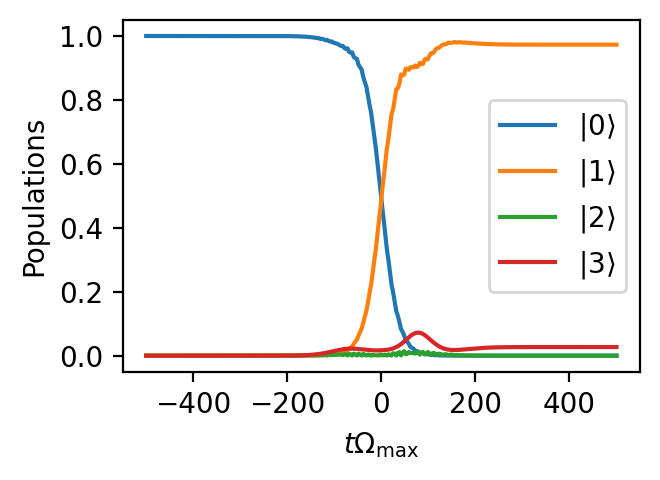

In [9]:
fig, ax = plt.subplots(figsize=[3.4, 2.5])
fig.set_dpi(200)
ax.plot(t*0.05, populations[0])
ax.plot(t*0.05, populations[1])
ax.plot(t*0.05, populations[2])
ax.plot(t*0.05, populations[3])
ax.legend(
    [r"$|0\rangle$", r"$|1\rangle$", r"$|2\rangle$", r"$|3\rangle$"], loc="center right"
)
plt.xlabel(r"$t\Omega_\mathrm{max}$")
plt.ylabel("Populations")
plt.tight_layout()
#plt.savefig("figs/populations.png", dpi=600)

## Noise distribution

In [12]:
area = quad(lambda x: gaussian(x, σ), δ_lower, δ_higher)
print(f"integral of the function = {area}")

integral of the function = (0.9999994266968564, 8.668320228277793e-10)


In [13]:
X = rejection_sampling(gaussian, σ, 4000, [δ_lower, δ_higher], maxp=None)

Text(0, 0.5, '$p(\\delta)$')

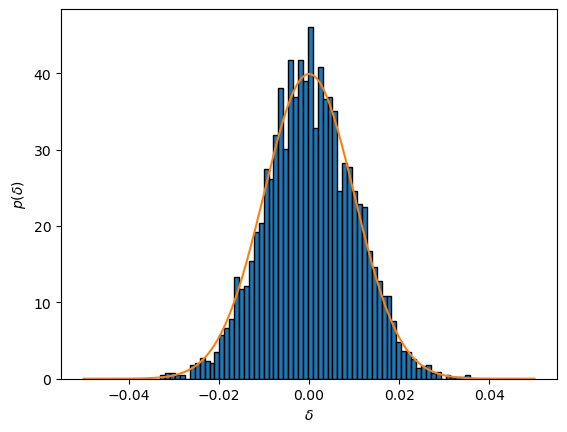

In [14]:
fig, ax = plt.subplots(1, 1)
y0, x0, _ = ax.hist(X, bins=int(np.sqrt(len(X))), density=True, edgecolor="black")
ax.plot(δrange, gaussian(δrange, σ))
ax.set_xlabel(r"$\delta$")
ax.set_ylabel(r"$p(\delta)$")

# Data generation

In [10]:
opts = Options(normalize_output = False, atol = 1e-11, rtol = 1e-9, nsteps = 10000)

In [11]:
# Maximum pulse amplitudes under three conditions: Ωs_max = Ωp_max, Ωs_max > Ωp_max, Ωs_max < Ωp_max
Ωs_max = np.array([0.05, np.sqrt(0.004), np.sqrt(0.001)])
Ωp_max = np.array([0.05, np.sqrt(0.001), np.sqrt(0.004)])

num_trajectories = 150
num_samples = 500

In [20]:
# check for generating 1 sample
import time

start_time = time.time()

eff_nonMarkovian(
    t,
    gaussian,
    pulse_ab,
    np.sqrt(0.004),
    np.sqrt(0.001),
    σ1=0.01,
    σ2=0.01,
    num_trajectories=2,
    η=1,
    pars=pars,
    opts=opts,
    noise=2,
)

end_time = time.time()

print(f"Execution time: {end_time - start_time} seconds")

Execution time: 8.686670541763306 seconds


## Data for correlated, non-Markovian quasistatic noise

In [34]:
# Range of correlation parameter η for correlated, non-Markovian quasistatic noise
ηrange_correlated = np.tan(np.random.uniform(np.arctan(1/5), np.arctan(5), num_samples))

data_CN = get_data_CN(
    t,
    gaussian,
    pulse_ab,
    Ωs_max,
    Ωp_max,
    σ,
    ηrange_correlated,
    num_trajectories,
    num_samples,
    pars,
    opts,
)

100%|█████████████████████████████████████████████| 1/1 [00:29<00:00, 29.93s/it]


In [35]:
efficiency_CN, y_CN, eta_CN = data_CN

In [ ]:
#save_object([efficiency_CN, y_CN, eta_CN], "./4-LEVEL_Datas/data_CN.pkl")

## Data for anti-correlated, non-Markovian quasistatic noise

In [38]:
# Range of correlation parameter η for anti-correlated, non-Markovian quasistatic noise
ηrange_anti_correlated = np.tan(np.random.uniform(np.arctan(-5), np.arctan(-1/5), num_samples))


data_ACN = get_data_CN(
    t,
    gaussian,
    pulse_ab,
    Ωs_max,
    Ωp_max,
    σ,
    ηrange_anti_correlated,
    num_trajectories,
    num_samples,
    pars,
    opts,
)


100%|█████████████████████████████████████████████| 1/1 [00:33<00:00, 33.12s/it]


In [40]:
efficiency_ACN, y_ACN, eta_ACN = data_ACN

In [28]:
#save_object([efficiency_ACN, y_ACN, eta_ACN],"4-LEVEL_Datas/data_ACN.pkl")

## Data for uncorrelated, non-Markovian quasistatic noise

In [42]:
num_trajectories = 120
#num_samples = 500, are calculated by parts

In [43]:
# Range of widths of the noise distributions
σ1 = np.random.uniform(low=σ / 5, high=5 * σ, size=num_samples)
σ2 = np.random.uniform(low=σ / 5, high=5 * σ, size=num_samples)

data_UCN = get_data_UCN(
    t,
    gaussian,
    pulse_ab,
    Ωs_max,
    Ωp_max,
    σ1,
    σ2,
    num_trajectories,
    num_samples,
    pars,
    opts,
)

100%|████████████████████████████████████████████| 1/1 [04:14<00:00, 254.70s/it]


In [46]:
efficiency_UCN, y_UCN = data_UCN

In [ ]:
#save_object([efficiency_UCN, y_UCN, (σ1, σ2)],"4-LEVEL_Datas/data_UCN.pkl",)

  0%|          | 0/90 [00:00<?, ?it/s]

## Data for correlated, Markovian noise

In [ ]:
# Range of correlation parameter η for correlated, Markovian noise
ηrange_correlated = np.tan(np.random.uniform(np.arctan(1/5), np.arctan(5), num_samples))
# Range of decay rate γ for correlated, Markovian noise
γrange = np.random.uniform(0.0001, 0.001, num_samples)

def get_data_CM_wrapper(i):
    result = get_data_CM(                          
    t, 
    pulse_ab, 
    Ωs_max, 
    Ωp_max, 
    γrange[i],
    ηrange_correlated[i],
    1, 
    pars, 
    opts
    )
    return result

In [23]:
data = []
with Pool(processes=cpu_count()) as pool:
    for x in tqdm(
        pool.imap(get_data_CM_wrapper, np.arange(num_samples)), total=num_samples
    ):
        data += [x]

100%|█████████████████████████████████████████████| 2/2 [00:25<00:00, 12.56s/it]


In [25]:
data_CM = process_parallel_data(data)

In [28]:
efficiency_CM, y_CM, eta_CM, γ_CM = data_CM

In [ ]:
#save_object([efficiency_CM, y_CM, eta_CM, γ_CM], "4-LEVEL_Datas/data_CM.pkl")

## Data for anti-correlated, Markovian noise

In [ ]:
# Range of correlation parameter η for anti-correlated, Markovian noise
ηrange_anti_correlated = np.tan(np.random.uniform(np.arctan(-5), np.arctan(-1/5), num_samples))

def get_data_ACM_wrapper(i):
    result = get_data_CM(                          
    t, 
    pulse_ab, 
    Ωs_max, 
    Ωp_max, 
    γrange[i],
    ηrange_anti_correlated[i],
    1, 
    pars, 
    opts
    )
    return result

In [31]:
data = []
with Pool(processes=cpu_count()) as pool:
    for x in tqdm(
        pool.imap(get_data_ACM_wrapper, np.arange(num_samples)), total=num_samples
    ):
        data += [x]

100%|█████████████████████████████████████████████| 2/2 [00:24<00:00, 12.28s/it]


In [32]:
data_ACM = process_parallel_data(data)

In [34]:
efficiency_ACM, y_ACM, eta_ACM, γ_ACM = data_ACM

In [ ]:
#save_object([efficiency_M_ACN, y_M_ACN, eta_M_ACN, γ_M_ACN], "4-LEVEL_Datas/data_ACM.pkl")

## Data for uncorrelated, Markovian noise

In [35]:
# Range of decay rates for uncorrelated, Markovian noise
γ1range = np.random.uniform(0.0001, 0.001, num_samples)
γ2range = np.random.uniform(0.0001, 0.001, num_samples)

In [38]:
def get_data_UCM_wrapper(i):
    result = get_data_UCM(                          
    t, 
    pulse_ab, 
    Ωs_max, 
    Ωp_max, 
    γ1range[i],
    γ2range[i],
    1, 
    pars, 
    opts
    )
    return result

In [39]:
data = []
with Pool(processes=cpu_count()) as pool:
    for x in tqdm(
        pool.imap(get_data_UCM_wrapper, np.arange(num_samples)), total=num_samples
    ):
        data += [x]

100%|█████████████████████████████████████████████| 2/2 [00:24<00:00, 12.29s/it]


In [40]:
data_UCM = process_parallel_data(data)

In [41]:
efficiency_UCM, y_UCM, γs_UCM = data_UCM

In [38]:
#save_object([efficiency_UCM, y_UCM, γs_UCM], "4-LEVEL_Datas/data_M_UC.pkl")